In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
from datetime import timedelta
recent_date = dt.datetime.strptime(recent_date, '%Y-%m-%d')
one_year_ago = recent_date - timedelta(days=365)
one_year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [11]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [12]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=["Date", "Precipitation"])
precipitation_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [13]:
# Sort the dataframe by date (query should have done this already, but confirm)
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values('Date')
precipitation_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [14]:
# Drop NaN values
precipitation_df = precipitation_df.dropna()
precipitation_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15


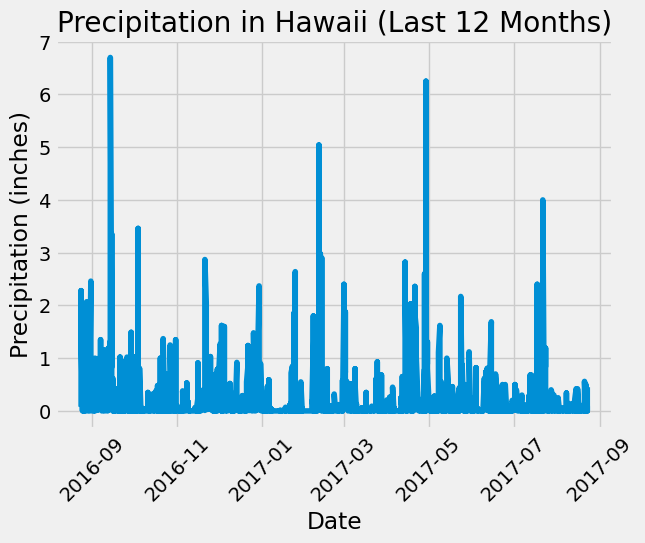

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')

plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)

plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe().to_frame().round(2)
precipitation_summary

,Precipitation
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Station.station, func.count(Measurement.station))\
    .join(Measurement, Measurement.station == Station.station)\
    .group_by(Station.station)\
    .order_by(func.count(Measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

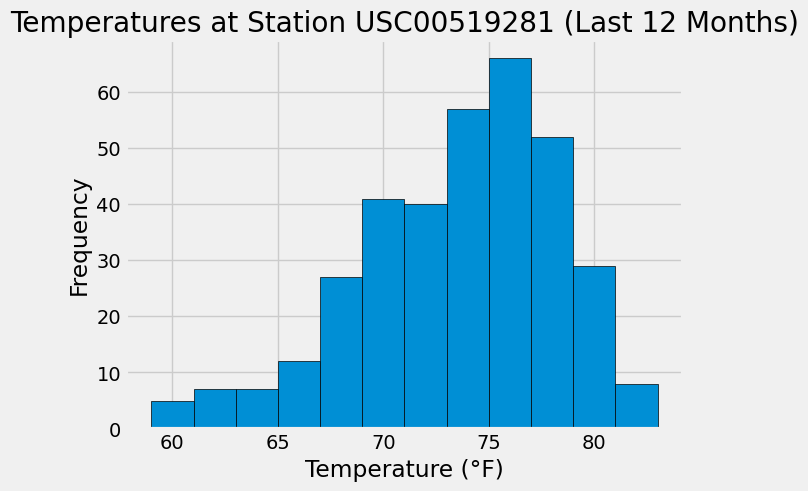

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    all()

# Convert the results into a list of temperature values
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, edgecolor='black')
plt.title(f"Temperatures at Station {most_active_station} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [21]:
# Close Session
session.close()